In [81]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from myUtils import *

import seaborn as sns
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 14)
%matplotlib inline

# n = pypsa.Network("../../results/smart/flex-2045/networks/base_s_27_3H_3H_2045.nc")
# n = pypsa.Network("../../results/smart/gas-2045/networks/base_s_27_3H_3H_2045.nc")
# n = pypsa.Network("../../results/smart/gas3/networks/base_s_27_3H_3H_2035.nc")
# n = pypsa.Network("../../results/smart/current/networks/base_s_27_3H_3H_2045.nc")
n = pypsa.Network("../../results/smart/gas-2045-7/networks/base_s_27_3H_3H_2045.nc")



INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [74]:
import myUtils as utils
import importlib
importlib.reload(utils)

generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
generators = generator_df.groupby('carrier').sum().p_nom_opt 
g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt

h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
h2s =  h2_df.groupby('carrier').sum().p_nom_opt

biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
print(biomass.p_nom_opt.sum())
s = pd.concat([generators, generatorLinks,h2s])
# s = generators
# s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
# s['Solar'] = s['solar'] + s['solar-hsat']
# s['Onwind'] = s['onwind']
  

# s['Solardach'] = s['solar rooftop']
# # s['Erdgas CHP'] = s['urban central CHP']
# s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
# s['Biomasse CHP'] = biomass.p_nom_opt.sum() 
# s['Gesamt'] = s.sum()
  
# s = s.reindex(['Onwind', 'Offwind', 'Solar', 'Solardach','OCGT', 'Geothermal','H2 Fuel Cell', 'H2 turbine', 'Biomasse CHP', 'ror', 'Gesamt'])
s  * 1.01 /1e3

0.036243839028537166


carrier
offwind-ac                          12.20484
offwind-dc                          65.70507
offwind-float                        0.53392
onwind                              66.06713
solar                               50.79005
solar rooftop                      166.33206
solar-hsat                           0.00008
H2 Fuel Cell                         0.00002
H2 turbine                           8.20767
OCGT                                26.51919
geothermal organic rankine cycle     0.00000
urban central CHP                    0.00048
urban central solid biomass CHP      0.00004
H2 Fuel Cell                         0.00002
H2 turbine                           8.20767
Name: p_nom_opt, dtype: float64

In [75]:
import myUtils as utils
import importlib
importlib.reload(utils)

generator = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_generator_grouper)

solar_rooftop_sum = generator.filter(like='solar rooftop').sum(axis=1).sum() * 3 / 1e6
solar_sum = generator.filter(like='solar').sum(axis=1).sum() * 3 / 1e6 - solar_rooftop_sum
offwind_ac_sum = generator.filter(like='offwind-ac').sum(axis=1).sum() * 3 / 1e6
offwind_dc_sum = generator.filter(like='offwind-dc').sum(axis=1).sum() * 3 / 1e6
offwind_float_sum = generator.filter(like='offwind-float').sum(axis=1).sum() * 3 / 1e6
onwind_sum = generator.filter(like='onwind').sum(axis=1).sum() * 3 / 1e6



OCGT_sum = utils.getNTimePropByGroup(n, 'Link','p0', utils.de_co2_generator_grouper).sum().sum() * 3 / 1e6

h2_FC_sum = utils.getNTimePropByGroup(n, 'Link','p0', utils.de_h2_FC_grouper).sum().sum() * 3 / 1e6
h2_turbine_sum = utils.getNTimePropByGroup(n, 'Link','p0', utils.de_h2_turbine_grouper).sum().sum() * 3 / 1e6


dict = {
  'offwind': offwind_ac_sum + offwind_dc_sum + offwind_float_sum,
  'onwind': onwind_sum,
  'solar rooftop': solar_rooftop_sum,
  'solar_sum': solar_sum,
  'h2': h2_FC_sum + h2_turbine_sum,
  'OCGT': OCGT_sum
}

print(dict)

# generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
# generators = generator_df.groupby('carrier').sum().p_nom_opt 
# g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
# generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt

# h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
# h2s =  h2_df.groupby('carrier').sum().p_nom_opt

# biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
#   # print(biomass)
# s = pd.concat([generators, generatorLinks,h2s])

{'offwind': 438.7540723525903, 'onwind': 138.02372654380244, 'solar rooftop': 157.05840594872444, 'solar_sum': 48.16100109357444, 'h2': 0.680470672124762, 'OCGT': 2.3020635241979117}


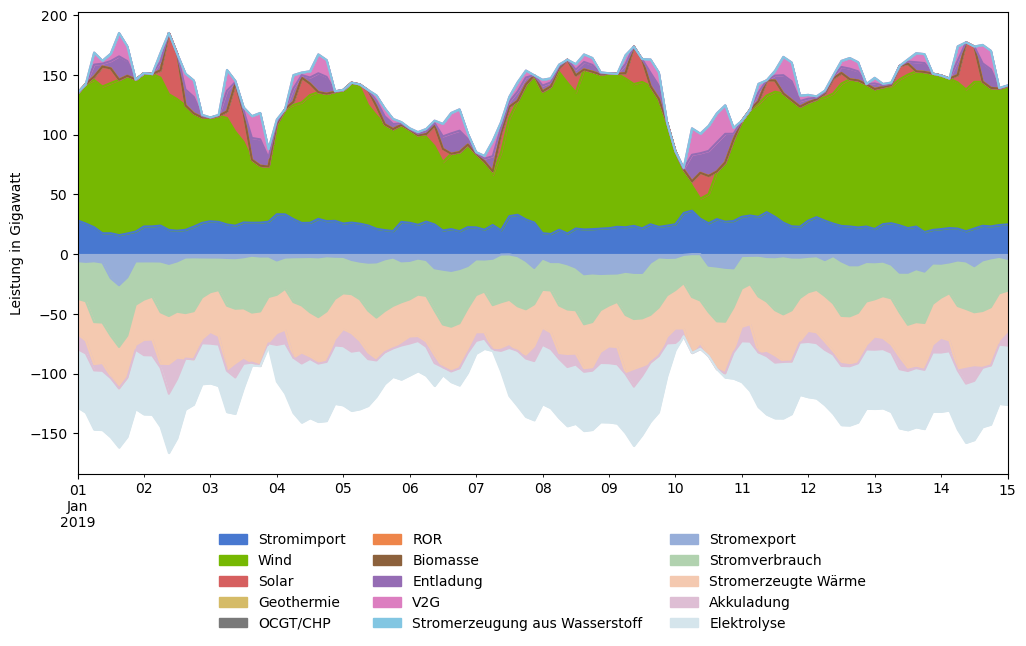

In [76]:
import pandas as pd
import myUtils as utils
import importlib
from matplotlib.dates import DateFormatter

plt.style.use('seaborn-v0_8-muted')
importlib.reload(utils)


df = pd.DataFrame(index = n.snapshots)

# supply

importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()

df['Stromimport'] = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)


generatorGeneratorIds =  utils.de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  utils.de_generator_grouper(n, 'Link').tolist()


windGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_wind_generator_grouper)
df['Wind'] =  windGeneratorP.sum(axis=1)
pvGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_pv_generator_grouper)
df['Solar'] =  pvGeneratorP.sum(axis=1)
co2GeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_co2_generator_grouper)
biomassGeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_biomass_generator_grouper)

rorGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_ror_generator_grouper)
geothermalGeneratorP = utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_geothermal_generator_grouper)

df['Geothermie'] = - geothermalGeneratorP.sum(axis=1)

df['OCGT/CHP'] =  co2GeneratorP.sum(axis=1) 
df['ROR'] =  rorGeneratorP.sum(axis=1) 
df['Biomasse']=biomassGeneratorP.sum(axis=1)

# demand

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
v2gIds = utils.de_v2g(n, 'Store').tolist()
# df['Entladung'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) +  n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1) #\
df['Entladung'] =  n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)
df['V2G'] = n.storage_units_t.p_dispatch[v2gIds].sum(axis=1) \
  + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)

ids = utils.de_h2_dispatch_grouper(n, 'Link').tolist()
df['Stromerzeugung aus Wasserstoff'] = - n.links_t.p1[ids].sum(axis=1)
# use
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()

df['Stromexport'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  + n.lines_t.p1[importLineRIDS].clip(upper=0).sum(axis=1)

useLoadIds = utils.de_elec_use_grouper(n, 'Load').tolist()
useLinesWasteIds = utils.getIndexSeries(n.df('Line'), utils.getIndexDeInnerCarrier(n.df('Line'), 'AC'))
distributionP0 = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_elec_distrbution_use_grouper) 
distributionP1 = utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_elec_distrbution_use_grouper) 

df['Stromverbrauch'] = - n.loads_t.p[useLoadIds].sum(axis=1)  \
  - utils.getNTimePropByGroup(n, 'Link', 'p2', utils.de_elec_methanol_use).sum(axis=1) \
  - (n.lines_t.p0[useLinesWasteIds] + n.lines_t.p1[useLinesWasteIds]).sum(axis=1) \
  - (distributionP0 + distributionP1).sum(axis=1)
useLinkIds = utils.de_elec_use_grouper(n, 'Link').tolist()   
df['Stromerzeugte Wärme'] =  -n.links_t.p0[useLinkIds].clip(lower=0).sum(axis=1)
# print(311,  - n.loads_t.p[useLoadIds].sum(axis=1))
storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()


storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
useElectrolysisIds = utils.de_h2_Electrolysis_grouper(n, 'Link').tolist()
# df['Akkuladung'] =  n.storage_units_t.p[storeStorageIds].clip(upper=0).sum(axis=1)\
df['Akkuladung'] = n.stores_t.p[storeStoreIds].clip(upper=0).sum(axis=1) 

df['Elektrolyse'] = - n.links_t.p0[useElectrolysisIds].sum(axis=1) 

# total_use = (df['export'] + df['use']  + df['heat'])
# total_produce= (df['import'] + df['PV generator'] + df['dispatch'])
# print(n.statistics.capex(groupby="de_grouper").sum() / 1e9) # 71
# print(n.statistics.opex(groupby="de_grouper").sum() / 1e9) # 5

colors = {
  'Stromimport': '#4878D0',
  'Stromerzeugung aus Wasserstoff': '#82C6E2',
  'Entladung': '#956CB4',
   'V2G': '#DC7EC0',
  
  'Wind': '#76B802',
  'Solar': '#D65F5F',
  'Geothermie': '#D5BB67',
  'OCGT/CHP': '#797979',
  'ROR': '#EE854A',
  'Biomasse': '#8C613C',

  'Stromexport': '#97AED9',
  'Elektrolyse': '#D5E5EC',
  'Akkuladung': '#DEBED4',

  'Stromverbrauch': '#B1D2AF',
  'Stromerzeugte Wärme': '#F4C9B0',
}
df = df / 1e3

ax = df['2019-1-1 00:00:00': '2019-1-15 00:00:00'].plot(kind='area', figsize=(12,6), color=colors, grid=False )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
# ax.xaxis.set_major_formatter(DateFormatter(" %d %m"))
ax.set_ylabel('Leistung in Gigawatt')
ax.set_xlabel('')


area_colors = [polygon.get_facecolor() for polygon in ax.collections]
area_colors_rgb = [color[:3] for color in area_colors]


plt.show()


In [82]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,

    n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(n),
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

# caepx_base = df.loc['CAPEX', 'Base']
# caepx_changes = (df.loc['CAPEX', ['Mean', 'Optimist', 'Best']] - caepx_base) / caepx_base * 100

# elc_caepx_base = df.loc['Strom CAPEX', 'Base']
# elc_caepx_changes = (df.loc['Strom CAPEX', ['Mean', 'Optimist', 'Best']] - elc_caepx_base) / elc_caepx_base * 100

# table = utils.dataframe_to_table(df)
# print(table)
# print(caepx_changes)
# print(elc_caepx_changes)

print(df)

6 6 6
                                Base
Name                                
CAPEX(inkl. Nachbarländer) 629.15599
CAPEX                       66.67847
investierte CAPEX           53.76868
OPEX                        29.71253
Strom CAPEX                 36.09650
Strom Opex                   0.04954


In [78]:
n = pypsa.Network("../../resources/smart/current/networks/base_s_27_6H_6H_2045.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/maxiao/Documents/code/rli-code/pypsa-eur-flexibility/resources/smart/current/networks/base_s_27_6H_6H_2045.nc'

In [ ]:
# battery
battery = utils.getNByGroup(n, 'Store', utils.de_battery_store)

print(battery.e_nom_opt.sum()  / 1e3)

battery = utils.getNByGroup(n, 'Link', utils.de_battery_discharger)
print(battery.p_nom_opt.sum() / 1e3) 

batteryT = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_battery_discharger)
print(batteryT.sum(axis=1).sum() *3 / 1e6) 

58.449704244475114
19.27502911796833
13.950624510784834


In [ ]:
# v2g
v2g = utils.getNByGroup(n, 'Store', utils.de_ev_battery)
print(v2g.e_nom_opt.sum() / 1e3) 

battery = utils.getNByGroup(n, 'Link', utils.de_v2g)
print(battery.p_nom_opt.sum() / 1e3) 

batteryT = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_v2g)
print(batteryT.sum(axis=1).sum() *3 )

1013.9645112499998
223.07219247499992
0.0


In [ ]:
v2g = utils.getNByGroup(n, 'Store', utils.de_ev_battery)
print(v2g.e_nom_opt.sum() / 1e3) 

battery = utils.getNByGroup(n, 'Link', utils.de_v2g)
print(battery.p_nom_opt.sum() / 1e3) 

batteryT = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_v2g)
print(batteryT.sum(axis=1).sum() *3 / 1e6)

1013.9645112499998
223.07219247499992
16.53165472146191


In [ ]:
v2g = utils.getNByGroup(n, 'Store', utils.de_h2_store_grouper)
print(v2g.e_nom_opt.sum() / 1e3) 

# battery = utils.getNByGroup(n, 'Link', utils.de_v2g)
# print(battery.p_nom_opt.sum() / 1e3) 

# batteryT = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_v2g)
# print(batteryT.sum(axis=1).sum() *3 / 1e6)

853.9120822839043


In [ ]:
v2g = utils.getNByGroup(n, 'Store', utils.de_h2_store_grouper)
print(v2g.e_nom_opt.sum() / 1e3) 

853.9120822839043


In [ ]:
importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()


tramission = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)

print(tramission.sum() / 1e6)

link = utils.getNByGroup(n, 'Link', utils.de_import_elec_grouper)
line = utils.getNByGroup(n, 'Link', utils.de_import_elec_grouper)

(link.p_nom_opt.sum()  + line.p_nom_opt.sum()) / 1e3


57.1658230186778


27.46178334596048

In [ ]:
ids = utils.de_h2_dispatch_grouper(n, 'Link').tolist()
- n.links_t.p1[ids].sum(axis=1).sum() / 1e3

0.004813982921926144

In [ ]:
# battery = utils.getNTimePropByGroup(n, 'Link', utils.de_v2g)

n.links_t.p_max_pu['DE0 0 V2G'].min()

0.6247798828210298

In [ ]:
2 ** 0.5

1.4142135623730951